<br/>

<!-- <p style="text-align:center;font-weight:bold;font-size:400%">Model-Free Prediction - Part 1</p> -->
<img src="assets/title_part1.png"/>

# Introduction

Part I of algorithms presented in Lecture 4 of UCL RL course by David Silver. Part II is [here](ModelFreePrediction_Part2.ipynb).

Notes:
* We are doing state-value function evaluation V(s), algorithms can be equally well applied to Q(s,a)
* We are performing fixed-policy evaluation only, no policy improvement


Algorithms:
* Every-Visit Monte-Carlo
* Incremental Monte-Carlo
* Running Mean Monte-Carlo
* Offline Temporal-Difference Learning
* Online Temporal-Difference Learning

Sources:
* UCL Course on RL: http://www0.cs.ucl.ac.uk/staff/d.silver/web/Teaching.html
  * Lecture 4 pdf: http://www0.cs.ucl.ac.uk/staff/d.silver/web/Teaching_files/MC-TD.pdf
  * Lecture 4 vid: https://www.youtube.com/watch?v=PnHCvfgC_ZA

Imports:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
import gym
np.set_printoptions(linewidth=115)  # nice printing of large arrays

# Blackjack

<img src="assets/blackjack.png"/>

Environment is a simplified version of casino Blackjack game

Rules summary:
* game is placed with an infinite deck (or with replacement)
* face cards (Jack, Queen, King) have point value 10
* aces can either count as 11 or 1, and it's called 'usable' at 11.
* goal is to get as near to 21 as possible w/o going over
* game is played against a dealer
* game starts with each (player and dealer) having one face up and one face down card

Observation is 3-tuple:
* the players __current sum__
* the __dealer's one showing card__ (1-10 where 1 is ace)
* and whether or not the player holds a __usable ace__ (0 or 1)

Actions:
* __1__ - hit - player requests another card
* __0__ - stick - player decides to stop, then dealer draws cards

Reward, on game end (player sticks or goes bust):
* __-1__ - if player goes bust, or dealer has more points
*  __0__ - if neither goes bust, and have equal points
* __+1__ - if dealer goes bust, or player has more points

As we see, action space is discrete, with only two possible actions:

In [2]:
env = gym.make('Blackjack-v0')
env.action_space

Discrete(2)

Observation space is a bit more complex, it is 3-tuple

In [3]:
env.observation_space

Tuple(Discrete(32), Discrete(11), Discrete(2))

In the following sections, we will have to create arrays for counting state-visits, state-values etc. We will define these arrays as 3d-arrays (dims being player_sum, dealer_card, usable_ace). This could be done with dictionary, but arrays are much faster. Becouse our observation values range from 12-21 for player_sum and 1-11 for dealer_card we will end up with a lot of always-zero entries. This is small memory cost for speedup of using array. Obviously we will have to remove zero entries before plotting.

In [4]:
obs_shape = [32, 11, 2]

# Player Policy

We are only concrerned with policy evaluation, as such player will follow fixed naive policy. The player will always hit if sum so far is less than 20, and hit is player sum is over-or-equal 20

In [5]:
# Player policy, explained in next section
def policy(obs):
    p_sum, d_card, p_ace = obs
    if p_sum >= 20:
        return 0  # stick
    else:
        return 1  # hit

# Helper Functions

All MC algorithms need to generate episodes before learning, lets define helper function. Looking at the code around the internet you will see many ways to define main loop. Sometimes env.reset() is placed before loop. Sometimes 'done' check is performed in different location in the loop etc.

I like to define it as below becouse of couple reasons:
* timestep boundries overlap with while-loop boundries
* timestep boundries follow Sutton & Barto convention (also used in David Silver slides)
* env.reset() doesn't require special treatment, which is useful later when we do TD

In [6]:
def genearte_episode():
    trajectory = []
    
    done = True
    while True:
        
        # === time step starts ===
        
        if done:
            obs, reward, done    = env.reset(), None, False
        else:
            obs, reward, done, _ = env.step(action)
        obs = tuple(np.array(obs, dtype=int))  # conv to int for indexing
                
        action = policy(obs)
        
        trajectory.append((obs, reward, done, action))
        
        if done:
            break
            
        # === time step ends here ===
        
    return trajectory

Also a small function to print trajectory. I used it for debugging

In [7]:
def print_trajectory():
    for obs, reward, done, action in trajectory:
        print('obs=', obs, '   Rt=', reward, '   done=', done, '   act=', action)

Helper function to plot blackjack state-values

In [8]:
def plot_blackjack(V):
    def plot_3d_wireframe(ax, Z):
        dealer_card = list(range(1, 11))
        player_points = list(range(12, 22))
        X, Y = np.meshgrid(dealer_card, player_points)
        ax.plot_wireframe(X, Y, Z)
    
    # Remove zero entries
    V = V[12:22,1:,:]

    # create figures
    fig = plt.figure(figsize=[16,3])
    ax_no_ace = fig.add_subplot(121, projection='3d', title='No Ace')
    ax_with_ace = fig.add_subplot(122, projection='3d', title='With Ace')
    
    # plot
    plot_3d_wireframe(ax_no_ace, V[:,:,0])   # plot no-ace
    plot_3d_wireframe(ax_with_ace, V[:,:,1]) # plot with-ace

# Every-Visit Monte-Carlo

Every-Visit Monte-Carlo algorithm:
* Repeat until completed:
  * generate one full episode
  * for each state within episode:
    * increment per-state counter &nbsp; $ N(S_t) \leftarrow N(S_t) + 1 $
    * sum up per-state return &nbsp; $ Sum(S_t) \leftarrow Sum(S_t) + G_t $
* at the end, for each state $ V(s) = Sum(s)\ / \ N(s) $

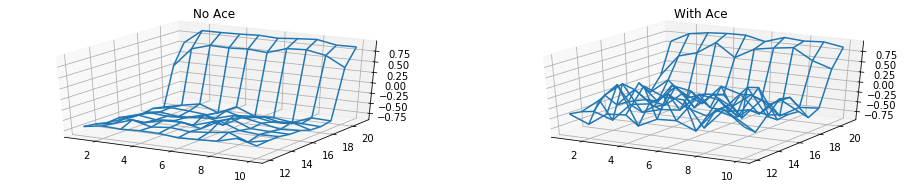

In [9]:
N = np.ones(obs_shape)   # count state visits (see note #1)
Sum = np.zeros(obs_shape)  # sum of state returns

for ep in range(10000):
    trajectory = genearte_episode()
    Gt = trajectory[-1][1]  # shortcut (see note #2)
    for obs, _, _, _ in trajectory[:-1]:  # never evaluate terminal states (see note #3)
        N[obs] += 1
        Sum[obs] += Gt

V = Sum / N  # calculate state-values

plot_blackjack(V)

__*Note #1__. Initialize __N=1__. We initialise visit counter N to one instead of zero. This is to avoid divide-by-zero in case state was not visited.

__*Note #2__. $G_t = R_{t=T}$. Technically we should use proper equation to calculate __Gt__, but notice that Blackjack is special case where reward is always awarded at the end of episode and we use discount equal 1. So:
$$ G_t = R_{t+1} + \gamma R_{t+2} + \gamma^2 R_{t+3} + ... $$
reduces to:
$$G_t = R_{t=T}$$
if
$$ \gamma=1 \quad and \quad R_{t+1} = R_{t+2} = R_{t+3} = ... = R_{T-1} = 0$$

__*Note #3__. Do not evaluate terminal states. State-Value of terminal state is always zero, game finished, there will be no future reward, ever. Especially in gym implementation of blackjac, if player 'sticks', then environment will return same observation again, this time with done==True and we would end up double counting last state.

# Incremental Monte-Carlo

Every-Visit Monte-Carlo algorithm:
* Repeat until completed:
  * generate one full episode
  * for each state within episode:
    * $ N(S_t) \leftarrow N(S_t) + 1 $ &nbsp; increment per-state counter
    * $ V(S_t) \leftarrow V(S_t) + \color{red}{\frac{1}{N(S_t)}}  \color{black}{(G_t-V(S_t))} $

Changes from Every-Visit MC:
* safe to init coutner N to zeros
* we no longer need S array

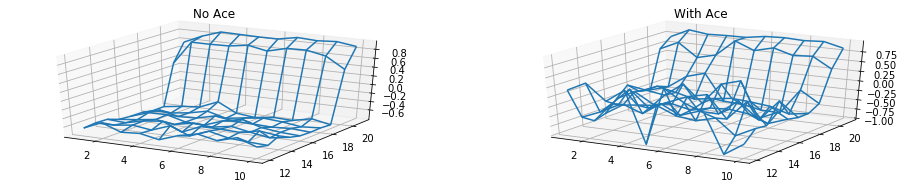

In [10]:
N = np.zeros(obs_shape)   # count state visits (see note #1)
V = np.zeros(obs_shape)   # state-values

for ep in range(10000):
    trajectory = genearte_episode()
    Gt = trajectory[-1][1]  # shortcut (see note #2)
    for obs, _, _, _ in trajectory[:-1]:  # never evaluate terminal states (see note #3)
        N[obs] += 1
        V[obs] = V[obs] + (1/N[obs]) * (Gt - V[obs])

plot_blackjack(V)

# Running-Mean Monte-Carlo

Running-Mean Monte-Carlo algorithm:
* Repeat until completed:
  * generate one full episode
  * for each state within episode:
    * $ V(S_t) \leftarrow V(S_t) + \gamma(\color{red}{G_t} \color{black}{-V(S_t))} $

Changes from Incremental MC:
* no longer need counter N
* technically, we should decay $\alpha$ over time to guarantee convergence, mech

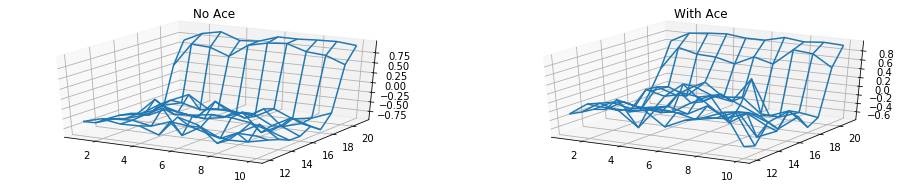

In [11]:
alpha = 0.1 # 1.0
V = np.zeros(obs_shape)  # state-values

for ep in range(10000):
    trajectory = genearte_episode()
    Gt = trajectory[-1][1]  # shortcut (see note #2)
    for obs, _, _, _ in trajectory[:-1]:  # never evaluate terminal states (see note #3)
        N[obs] += 1
        V[obs] = V[obs] + alpha * (Gt - V[obs])
    #alpha *= 0.999  # decay alpha, choosen empirically

plot_blackjack(V)

# Temporal-Difference Learning

### Offline TD

Offline Temporal-Difference Learning algorithm:
* Repeat until completed:
  * generate one full episode
  * for each state within episode:
    * $ V(S_t) \leftarrow V(S_t) + \alpha( \color{red}{R_{t+1}+\gamma V(S_{t+1})} \color{black}{-V(S_t))} $

As mentioned before, we need to guarantee that state-value of terminal states is always zero, if terminal states are distinct from normal states, then there is no need for explicit logic. In our case we have to handle terminal states separately

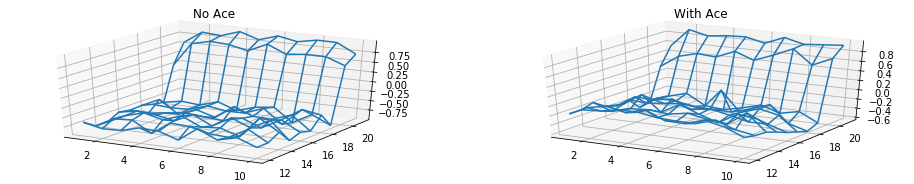

In [12]:
alpha = 0.1
V = np.zeros(obs_shape)

for ep in range(10000):
    trajectory = genearte_episode()
    Gt = trajectory[-1][1]  # shortcut (see note #2)
    for t in range(len(trajectory)-1):  # never evaluate terminal states (see note #3)
        St, _, _, _ = trajectory[t]
        St_1, Rt_1, done, _ = trajectory[t+1]

        if not done:
            V[St] = V[St] + alpha * (Rt_1 + V[St_1] - V[St])
        else:
            V[St] = V[St] + alpha * (Rt_1 +    0    - V[St])

plot_blackjack(V)

### Online TD

Online Temporal-Difference Learning algorithm:
* Repeat until completed:
  * generate single time-step
  * $ V(S_t) \leftarrow V(S_t) + \alpha( \color{red}{R_{t+1}+\gamma V(S_{t+1})}  \color{black}{-V(S_t))} $

Technically we no longer need 'trajectory', as we don't need to remember more than one previous state. But I like to keep things consistent. If you implement agent that can switch between different algorithms, you will almost always need 'trajectory' for something anyway.

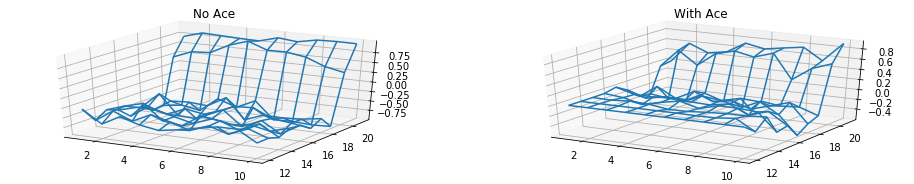

In [13]:
alpha = 0.1
V = np.zeros(obs_shape)

for ep in range(10000):
    trajectory = []
    
    done = True
    while True:
        
        # === time step starts ===
        
        if done:
            obs, reward, done    = env.reset(), None, False
        else:
            obs, reward, done, _ = env.step(action)
        obs = tuple(np.array(obs, dtype=int))  # conv to int for indexing
        
        # perform TD update from the perspective of previous step
        # PREVIOUS STEP is t, CURRENT STEP is t+1
        if len(trajectory) >= 2:  # 
            St, _, _, _ = trajectory[-1]
            St_1, Rt_1 = obs, reward
            if not done:
                V[St] = V[St] + alpha * (Rt_1 + V[St_1] - V[St])
            else:
                V[St] = V[St] + alpha * (Rt_1 +    0    - V[St])
        
        action = policy(obs)
        
        trajectory.append((obs, reward, done, action))
        
        if done:
            break
            
        # === time step ends here ===
        
plot_blackjack(V)